In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
786   -0.336840
787   -0.162550
788    0.054420
789    0.320210
790    0.440940
791    0.622760
792    0.669080
793    0.571440
794    0.314550
795   -0.117950
796   -0.342410
797   -0.575180
798   -0.632610
799   -0.731040
800   -0.682790
801   -0.583980
802   -0.526500
803   -0.401330
804   -0.099234
805    0.089021
806    0.272670
807    0.460950
808    0.563090
809    0.588340
810    0.442490
811    0.217700
812    0.002681
813   -0.213860
814   -0.343190
815   -0.396610
Name: f0, Length: 816, d

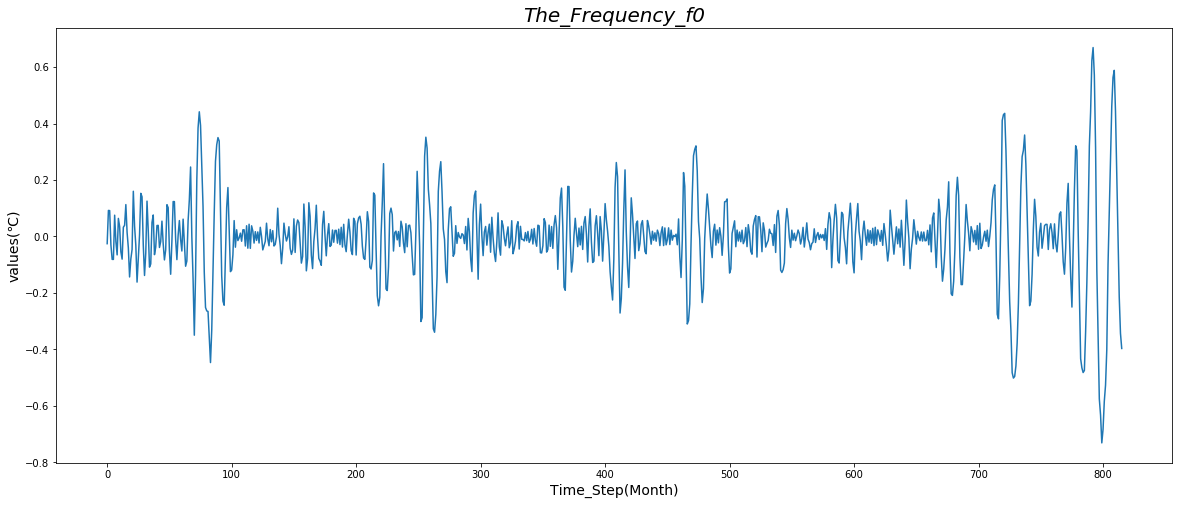

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 6s - loss: 0.0180
Epoch 2/200
 - 2s - loss: 0.0179
Epoch 3/200
 - 2s - loss: 0.0177
Epoch 4/200
 - 2s - loss: 0.0176
Epoch 5/200
 - 2s - loss: 0.0170
Epoch 6/200
 - 2s - loss: 0.0167
Epoch 7/200
 - 2s - loss: 0.0164
Epoch 8/200
 - 2s - loss: 0.0153
Epoch 9/200
 - 2s - loss: 0.0151
Epoch 10/200
 - 2s - loss: 0.0144
Epoch 11/200
 - 2s - loss: 0.0139
Epoch 12/200
 - 2s - loss: 0.0146
Epoch 13/200
 - 2s - loss: 0.0136
Epoch 14/200
 - 2s - loss: 0.0130
Epoch 15/200
 - 2s - loss: 0.0131
Epoch 16/200
 - 2s - loss: 0.0122
Epoch 17/200
 - 4s - loss: 0.0130
Epoch 18/200
 - 3s - loss: 0.0129
Epoch 19/200
 - 3s - loss: 0.0136
Epoch 20/200
 - 3s - loss: 0.0123
Epoch 21/200
 - 3s - loss: 0.0117
Epoch 22/200
 - 2s - loss: 0.0115
Epoch 23/200
 - 2s - loss: 0.0113
Epoch 24/200
 - 2s - loss: 0.0117
Epoch 25/200
 - 2s - loss: 0.0112
Epoch 26/200
 - 2s - loss: 0.0107
Epoch 27/200
 - 2s - loss: 0.0107
Epoch 28/200
 - 2s - loss: 0.0106
Epoch 29/

(65, 12)


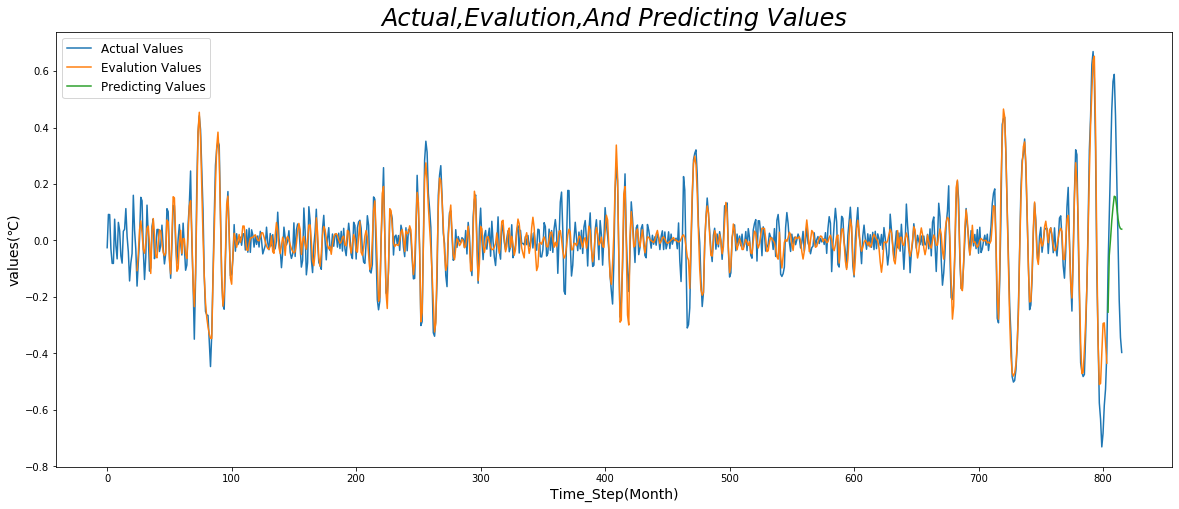

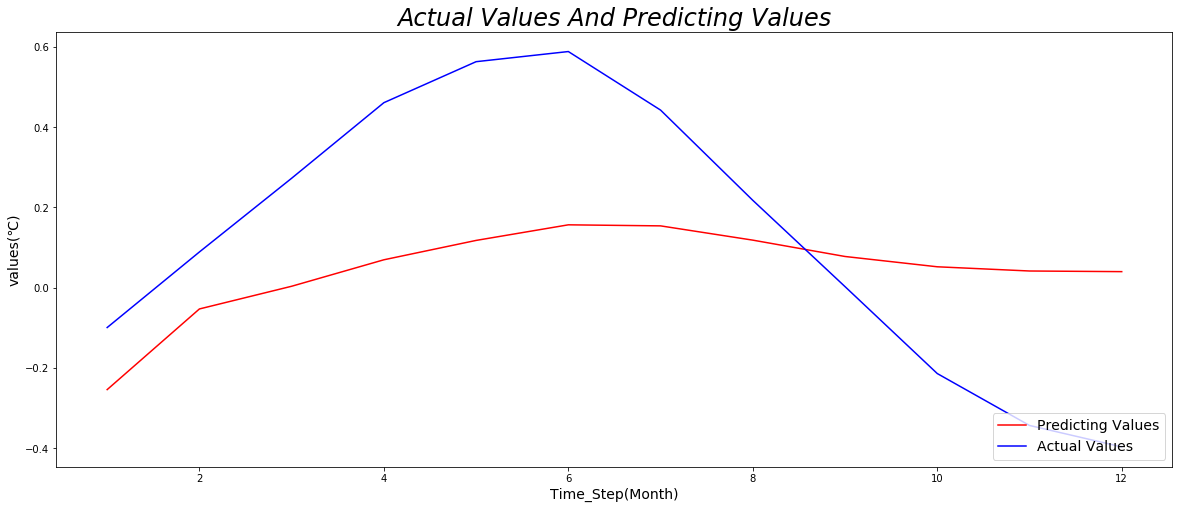

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
786    0.318450
787    0.365760
788    0.395270
789    0.405300
790    0.392990
791    0.350710
792    0.271820
793    0.161390
794    0.031368
795   -0.105260
796   -0.235530
797   -0.346450
798   -0.425050
799   -0.458350
800   -0.437380
801   -0.369290
802   -0.265440
803   -0.138090
804    0.000280
805    0.137210
806    0.260330
807    0.357270
808    0.416170
809    0.427090
810    0.384500
811    0.298550
812    0.183280
813    0.052754
814   -0.078966
815   -0.197830
Name: f1, Length: 816, d

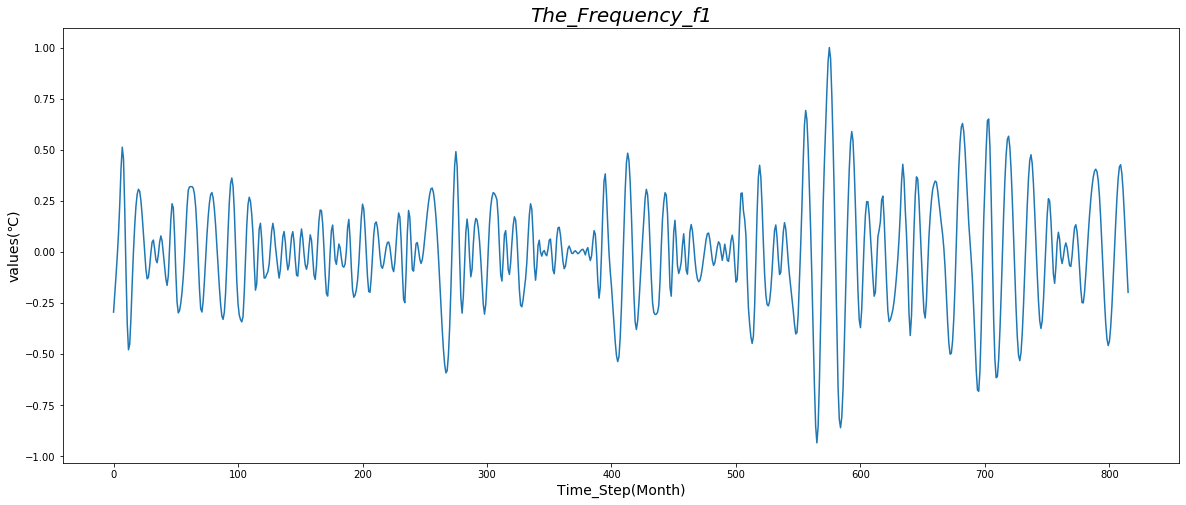

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 7s - loss: 0.0651
Epoch 2/200
 - 3s - loss: 0.0564
Epoch 3/200
 - 2s - loss: 0.0473
Epoch 4/200
 - 3s - loss: 0.0442
Epoch 5/200
 - 2s - loss: 0.0414
Epoch 6/200
 - 2s - loss: 0.0378
Epoch 7/200
 - 2s - loss: 0.0362
Epoch 8/200
 - 2s - loss: 0.0342
Epoch 9/200
 - 2s - loss: 0.0338
Epoch 10/200
 - 2s - loss: 0.0310
Epoch 11/200
 - 2s - loss: 0.0319
Epoch 12/200
 - 2s - loss: 0.0318
Epoch 13/200
 - 2s - loss: 0.0295
Epoch 14/200
 - 2s - loss: 0.0300
Epoch 15/200
 - 2s - loss: 0.0282
Epoch 16/200
 - 2s - loss: 0.0270
Epoch 17/200
 - 2s - loss: 0.0285
Epoch 18/200
 - 2s - loss: 0.0279
Epoch 19/200
 - 2s - loss: 0.0276
Epoch 20/200
 - 2s - loss: 0.0290
Epoch 21/200
 - 2s - loss: 0.0263
Epoch 22/200
 - 2s - loss: 0.0266
Epoch 23/200
 - 2s - loss: 0.0259
Epoch 24/200
 - 2s - loss: 0.0257
Epoch 25/200
 - 2s - loss: 0.0255
Epoch 26/200
 - 2s - loss: 0.0254
Epoch 27/200
 - 2s - loss: 0.0238
Epoch 28/200
 - 2s - loss: 0.0250
Epoch 29/200
 - 2s - loss: 0.0253
Epoch 30/200
 - 2s - lo

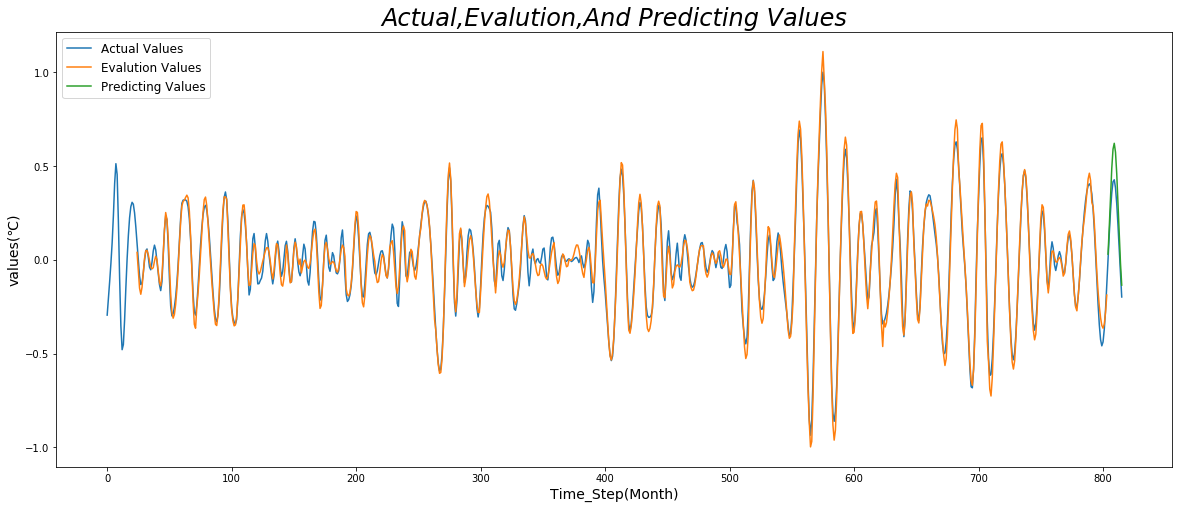

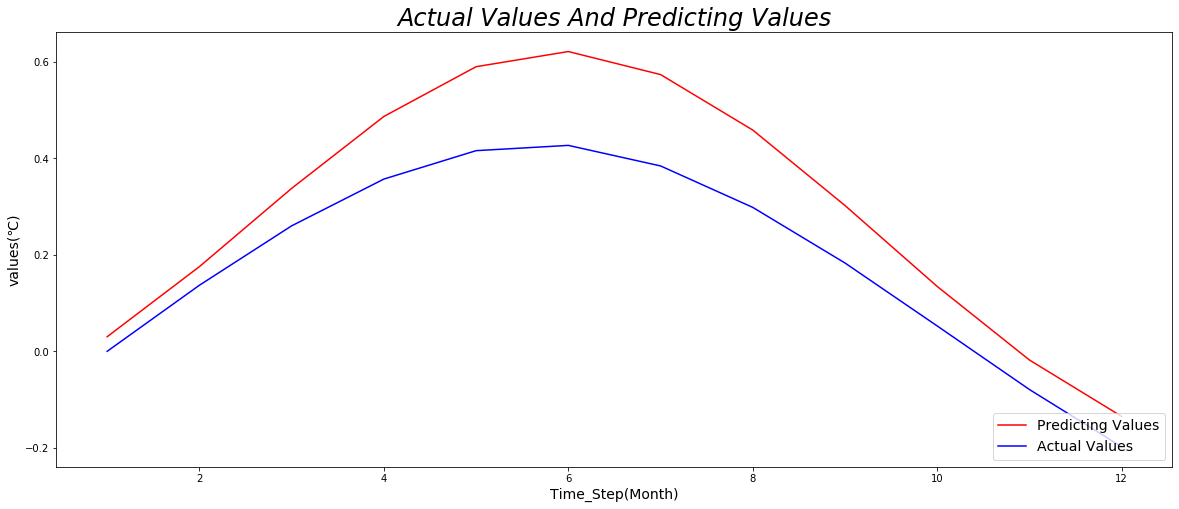

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
786    0.309220
787    0.348960
788    0.375580
789    0.385650
790    0.376110
791    0.347740
792    0.302830
793    0.243830
794    0.173170
795    0.093316
796    0.006694
797   -0.084249
798   -0.177070
799   -0.269330
800   -0.358600
801   -0.442530
802   -0.518820
803   -0.585140
804   -0.639180
805   -0.678640
806   -0.701300
807   -0.704980
808   -0.687930
809   -0.650280
810   -0.593070
811   -0.519160
812   -0.431370
813   -0.332330
814   -0.224710
815   -0.111170
Name: f2, Length: 816, d

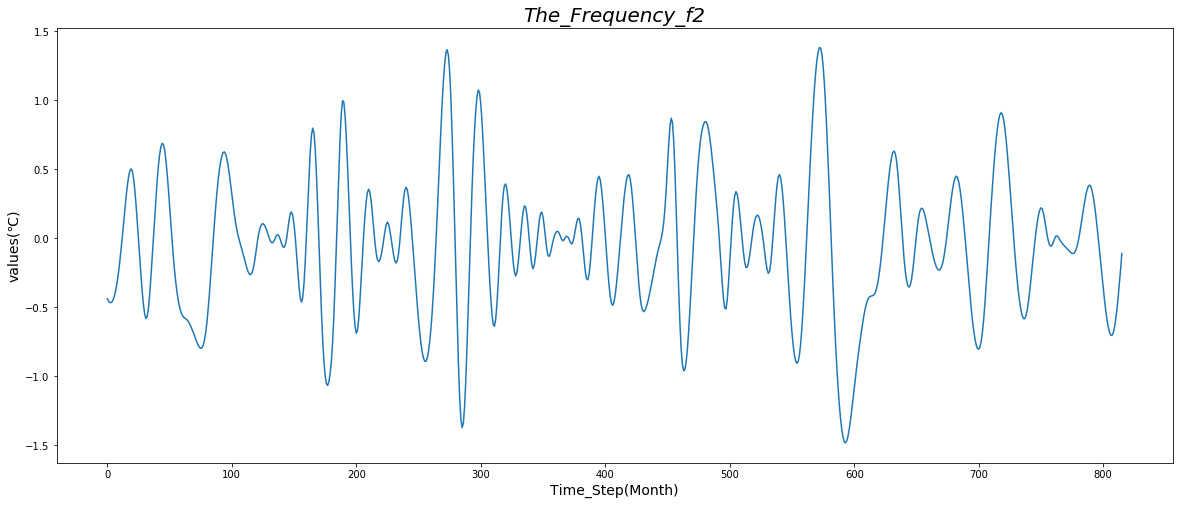

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 8s - loss: 0.2401
Epoch 2/200
 - 3s - loss: 0.2167
Epoch 3/200
 - 3s - loss: 0.2112
Epoch 4/200
 - 2s - loss: 0.1495
Epoch 5/200
 - 2s - loss: 0.1168
Epoch 6/200
 - 2s - loss: 0.1170
Epoch 7/200
 - 2s - loss: 0.1023
Epoch 8/200
 - 2s - loss: 0.0886
Epoch 9/200
 - 2s - loss: 0.0867
Epoch 10/200
 - 2s - loss: 0.0783
Epoch 11/200
 - 2s - loss: 0.0812
Epoch 12/200
 - 2s - loss: 0.0833
Epoch 13/200
 - 2s - loss: 0.0730
Epoch 14/200
 - 2s - loss: 0.0641
Epoch 15/200
 - 2s - loss: 0.0589
Epoch 16/200
 - 2s - loss: 0.0627
Epoch 17/200
 - 2s - loss: 0.0566
Epoch 18/200
 - 2s - loss: 0.0587
Epoch 19/200
 - 2s - loss: 0.0574
Epoch 20/200
 - 2s - loss: 0.0507
Epoch 21/200
 - 2s - loss: 0.0567
Epoch 22/200
 - 2s - loss: 0.0502
Epoch 23/200
 - 2s - loss: 0.0467
Epoch 24/200
 - 2s - loss: 0.0458
Epoch 25/200
 - 2s - loss: 0.0529
Epoch 26/200
 - 2s - loss: 0.0478
Epoch 27/200
 - 2s - loss: 0.0450
Epoch 28/200
 - 2s - loss: 0.0447
Epoch 29/200
 - 2s - loss: 0.0437
Epoch 30/200
 - 2s - lo

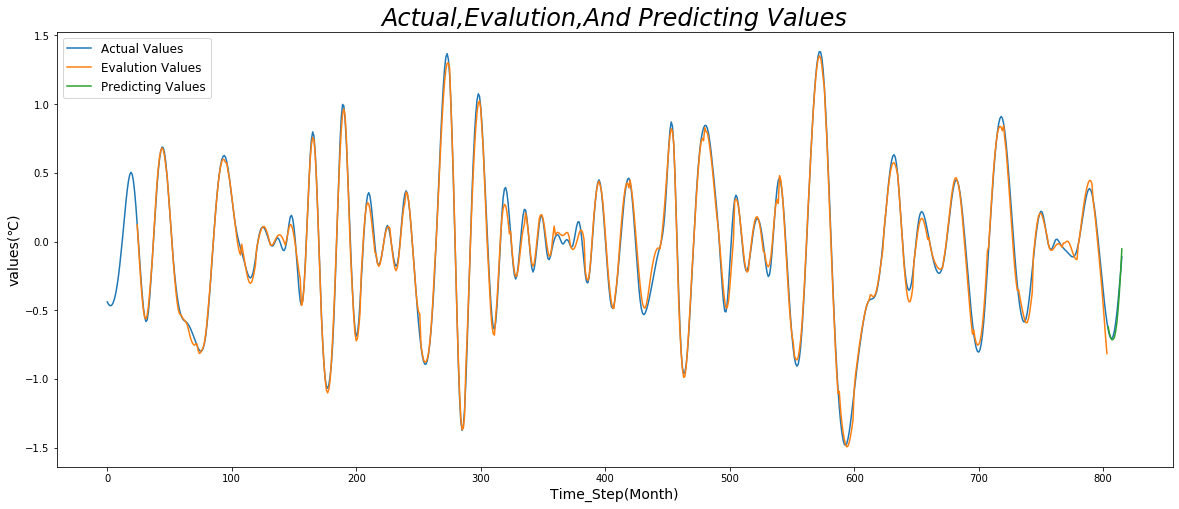

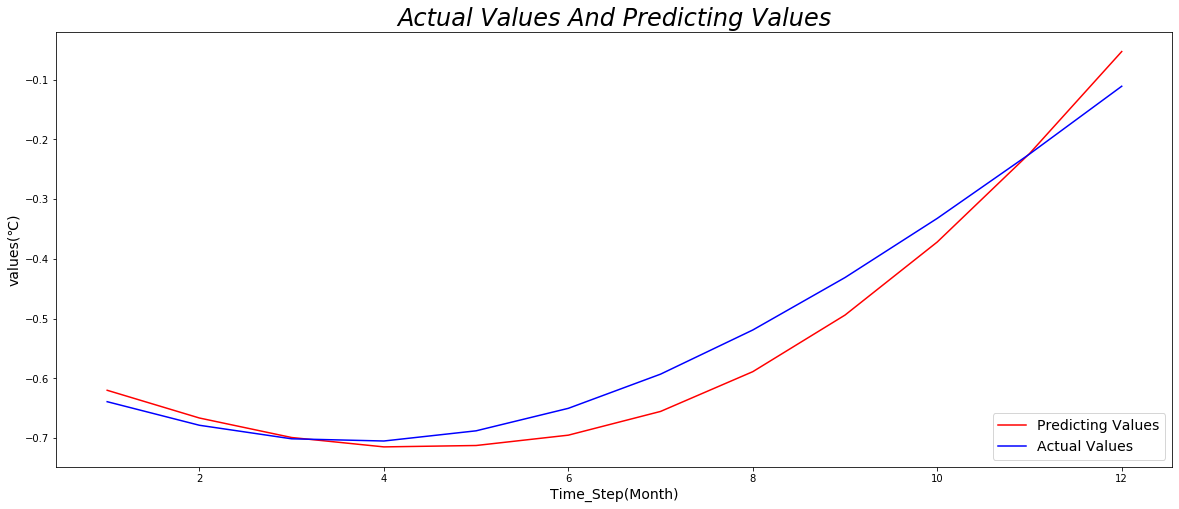

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
786    0.668030
787    0.693340
788    0.708090
789    0.711310
790    0.702810
791    0.683290
792    0.653620
793    0.614690
794    0.567370
795    0.512530
796    0.451040
797    0.383770
798    0.311610
799    0.235410
800    0.156060
801    0.074433
802   -0.008606
803   -0.092181
804   -0.175420
805   -0.257450
806   -0.337390
807   -0.414380
808   -0.487560
809   -0.556170
810   -0.619500
811   -0.677020
812   -0.728760
813   -0.774880
814   -0.815570
815   -0.850990
Name: f3, Length: 816, d

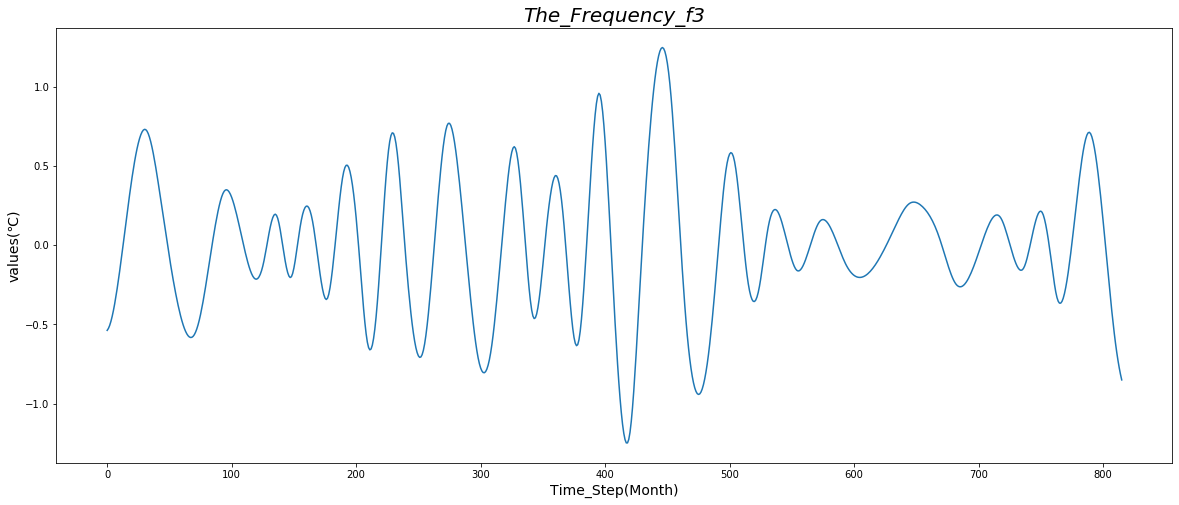

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 9s - loss: 0.1408
Epoch 2/200
 - 3s - loss: 0.0927
Epoch 3/200
 - 3s - loss: 0.0647
Epoch 4/200
 - 3s - loss: 0.0424
Epoch 5/200
 - 3s - loss: 0.0335
Epoch 6/200
 - 2s - loss: 0.0332
Epoch 7/200
 - 2s - loss: 0.0288
Epoch 8/200
 - 2s - loss: 0.0241
Epoch 9/200
 - 2s - loss: 0.0193
Epoch 10/200
 - 2s - loss: 0.0143
Epoch 11/200
 - 2s - loss: 0.0197
Epoch 12/200
 - 2s - loss: 0.0165
Epoch 13/200
 - 2s - loss: 0.0140
Epoch 14/200
 - 2s - loss: 0.0135
Epoch 15/200
 - 2s - loss: 0.0102
Epoch 16/200
 - 2s - loss: 0.0130
Epoch 17/200
 - 2s - loss: 0.0113
Epoch 18/200
 - 2s - loss: 0.0132
Epoch 19/200
 - 2s - loss: 0.0114
Epoch 20/200
 - 2s - loss: 0.0112
Epoch 21/200
 - 2s - loss: 0.0106
Epoch 22/200
 - 2s - loss: 0.0092
Epoch 23/200
 - 2s - loss: 0.0104
Epoch 24/200
 - 2s - loss: 0.0083
Epoch 25/200
 - 2s - loss: 0.0088
Epoch 26/200
 - 2s - loss: 0.0096
Epoch 27/200
 - 2s - loss: 0.0082
Epoch 28/200
 - 2s - loss: 0.0117
Epoch 29/200
 - 2s - loss: 0.0074
Epoch 30/200
 - 2s - lo

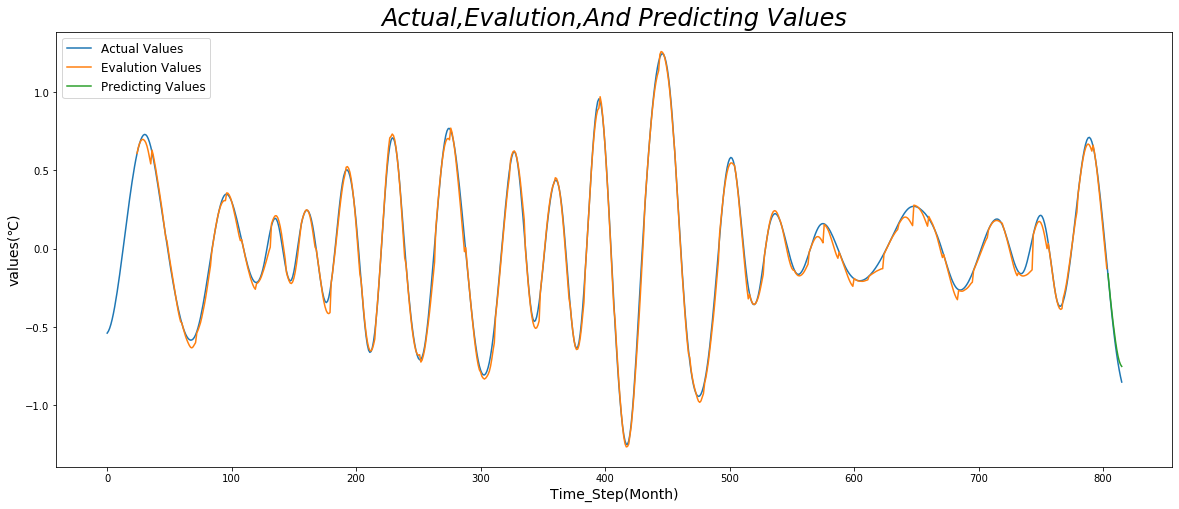

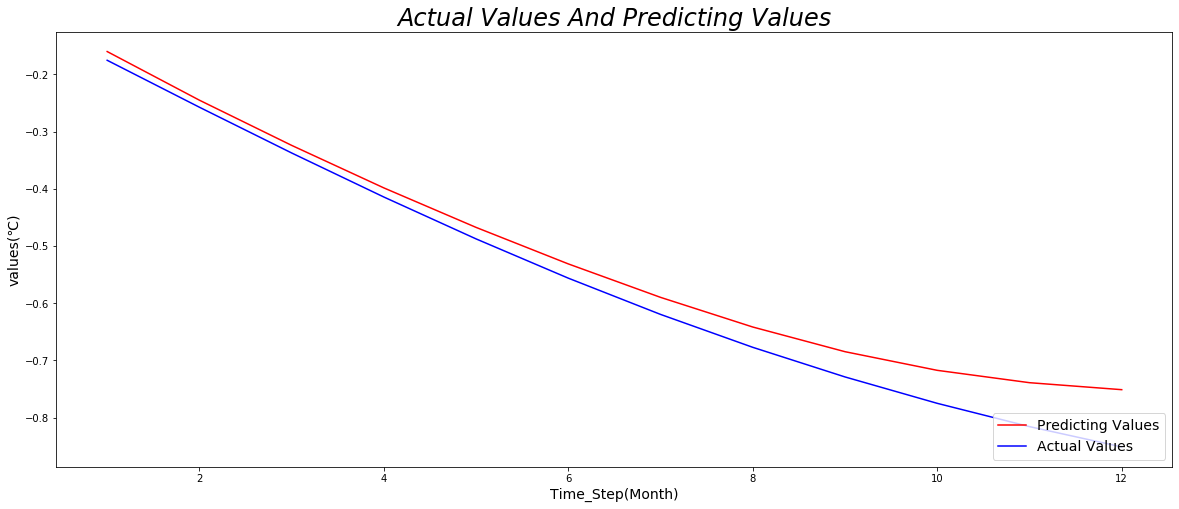

0     -0.21581
1     -0.21438
2     -0.21291
3     -0.21139
4     -0.20982
5     -0.20820
6     -0.20653
7     -0.20481
8     -0.20303
9     -0.20120
10    -0.19931
11    -0.19736
12    -0.19536
13    -0.19329
14    -0.19116
15    -0.18896
16    -0.18670
17    -0.18438
18    -0.18198
19    -0.17952
20    -0.17699
21    -0.17439
22    -0.17171
23    -0.16896
24    -0.16613
25    -0.16323
26    -0.16025
27    -0.15719
28    -0.15405
29    -0.15082
        ...   
786    0.40887
787    0.41909
788    0.42820
789    0.43617
790    0.44298
791    0.44865
792    0.45323
793    0.45678
794    0.45935
795    0.46099
796    0.46178
797    0.46175
798    0.46098
799    0.45951
800    0.45740
801    0.45470
802    0.45146
803    0.44774
804    0.44359
805    0.43905
806    0.43419
807    0.42906
808    0.42370
809    0.41817
810    0.41253
811    0.40681
812    0.40109
813    0.39541
814    0.38981
815    0.38436
Name: f4, Length: 816, dtype: float64
(816,)


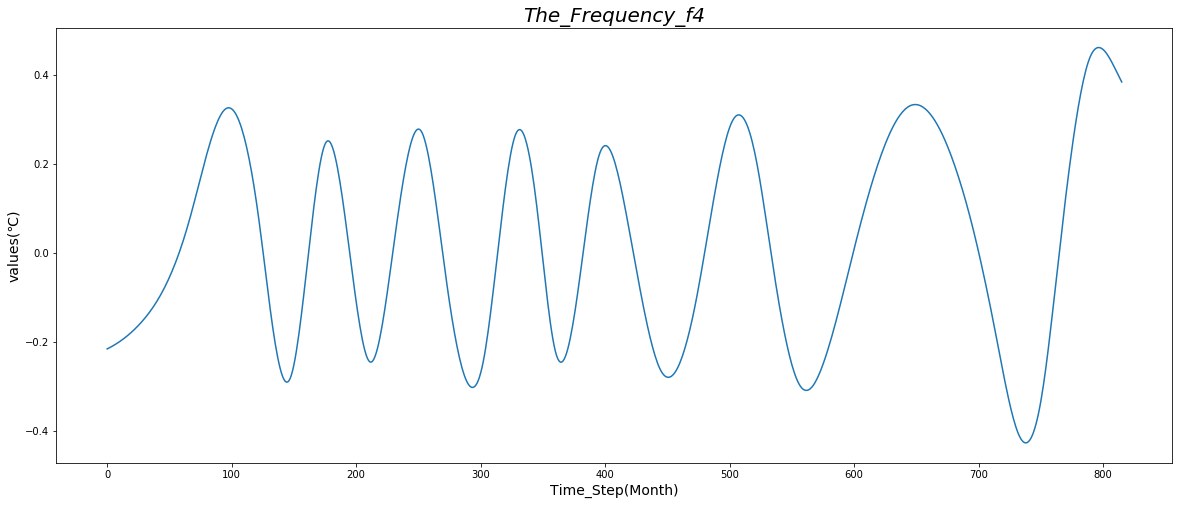

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 9s - loss: 0.0320
Epoch 2/200
 - 3s - loss: 0.0094
Epoch 3/200
 - 3s - loss: 0.0047
Epoch 4/200
 - 3s - loss: 0.0032
Epoch 5/200
 - 2s - loss: 0.0018
Epoch 6/200
 - 3s - loss: 0.0016
Epoch 7/200
 - 2s - loss: 0.0010
Epoch 8/200
 - 2s - loss: 0.0014
Epoch 9/200
 - 2s - loss: 0.0010
Epoch 10/200
 - 2s - loss: 7.8425e-04
Epoch 11/200
 - 2s - loss: 0.0011
Epoch 12/200
 - 2s - loss: 8.3114e-04
Epoch 13/200
 - 2s - loss: 0.0011
Epoch 14/200
 - 2s - loss: 8.3463e-04
Epoch 15/200
 - 2s - loss: 8.9387e-04
Epoch 16/200
 - 2s - loss: 7.9271e-04
Epoch 17/200
 - 2s - loss: 7.4943e-04
Epoch 18/200
 - 2s - loss: 7.1753e-04
Epoch 19/200
 - 2s - loss: 6.5076e-04
Epoch 20/200
 - 2s - loss: 8.6470e-04
Epoch 21/200
 - 2s - loss: 6.5138e-04
Epoch 22/200
 - 2s - loss: 6.6108e-04
Epoch 23/200
 - 2s - loss: 5.7706e-04
Epoch 24/200
 - 2s - loss: 6.8595e-04
Epoch 25/200
 - 2s - loss: 6.9959e-04
Epoch 26/200
 - 2s - loss: 5.9037e-04
Epoch 27/200
 - 2s - loss: 8.2023e-04
Epoch 28/200
 - 2s - loss: 

(65, 12)


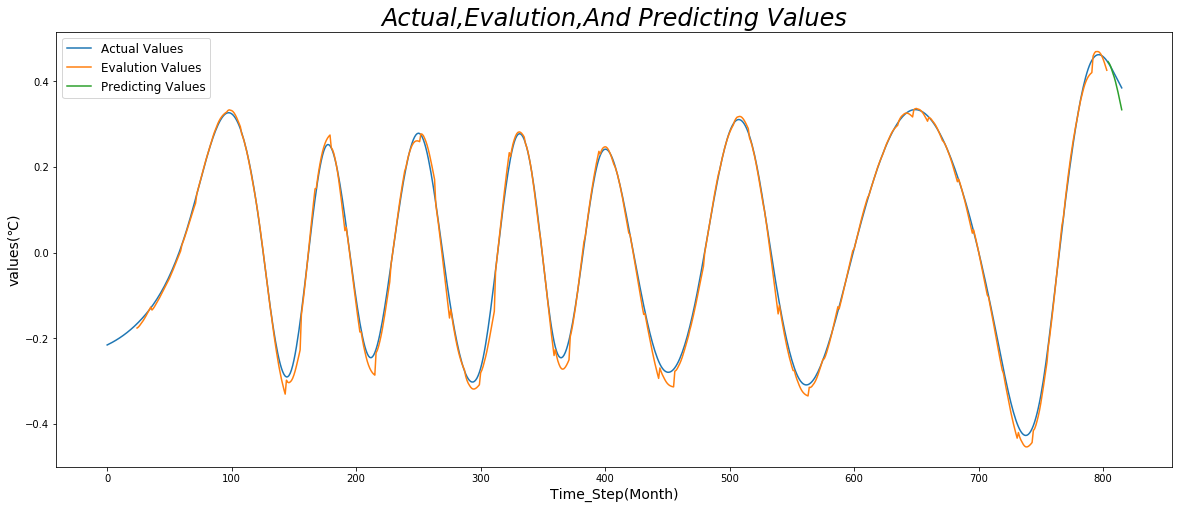

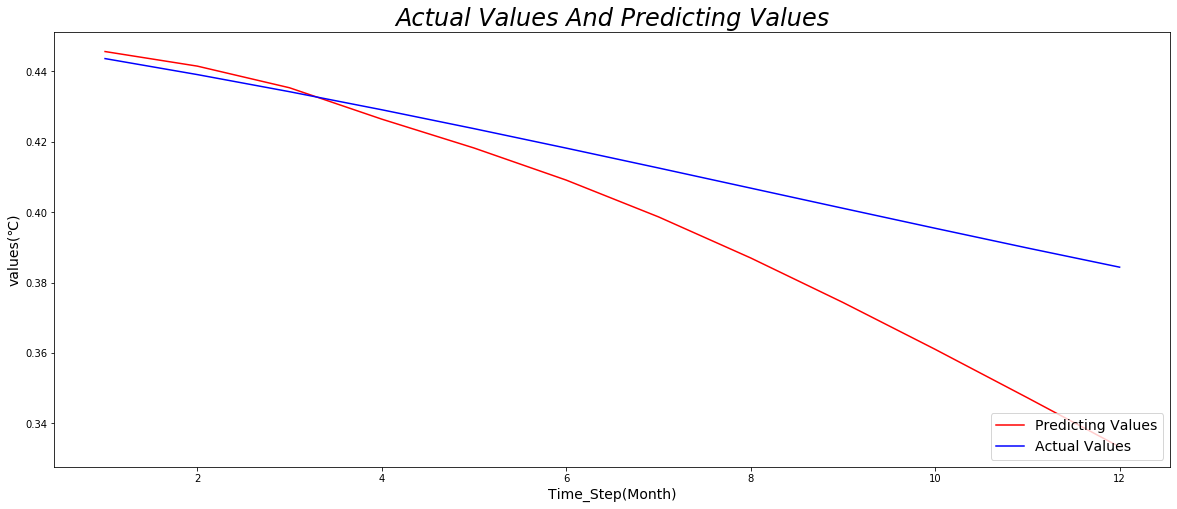

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
786    0.129540
787    0.131620
788    0.133610
789    0.135500
790    0.137280
791    0.138960
792    0.140530
793    0.142000
794    0.143350
795    0.144580
796    0.145700
797    0.146690
798    0.147570
799    0.148310
800    0.148940
801    0.149440
802    0.149830
803    0.150090
804    0.150240
805    0.150280
806    0.150200
807    0.150010
808    0.149720
809    0.149310
810    0.148800
811    0.148190
812    0.147470
813    0.146660
814    0.145740
815    0.144720
Name: f5, Length: 816, d

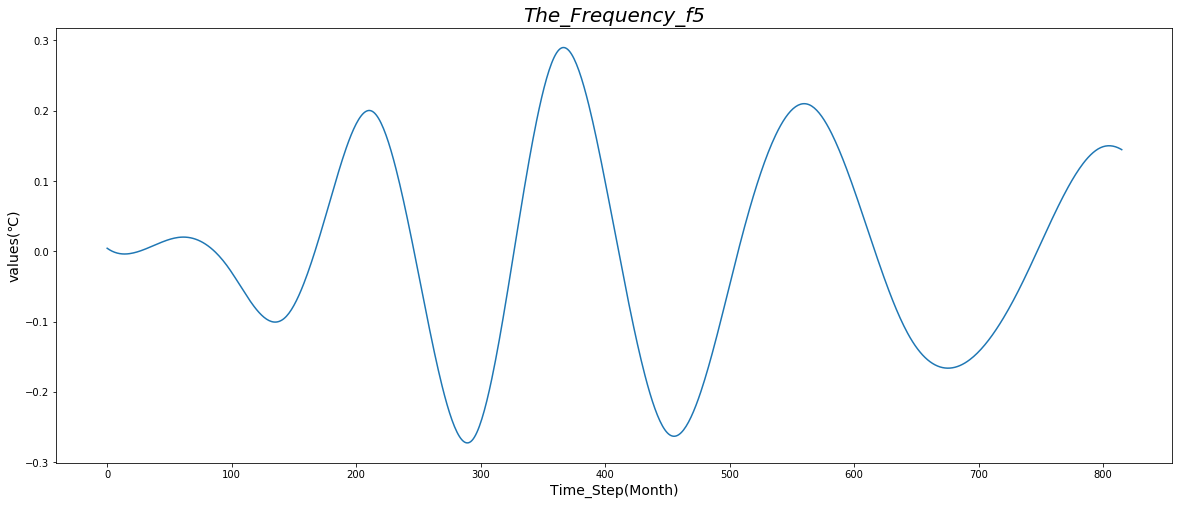

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 11s - loss: 0.0124
Epoch 2/200
 - 4s - loss: 0.0044
Epoch 3/200
 - 4s - loss: 0.0011
Epoch 4/200
 - 4s - loss: 5.0473e-04
Epoch 5/200
 - 4s - loss: 1.9959e-04
Epoch 6/200
 - 4s - loss: 9.9602e-05
Epoch 7/200
 - 4s - loss: 9.9361e-05
Epoch 8/200
 - 4s - loss: 9.9049e-05
Epoch 9/200
 - 4s - loss: 9.5180e-05
Epoch 10/200
 - 4s - loss: 6.5937e-05
Epoch 11/200
 - 4s - loss: 5.1624e-05
Epoch 12/200
 - 4s - loss: 6.3468e-05
Epoch 13/200
 - 4s - loss: 6.5095e-05
Epoch 14/200
 - 4s - loss: 5.0291e-05
Epoch 15/200
 - 4s - loss: 9.3517e-05
Epoch 16/200
 - 4s - loss: 9.8155e-05
Epoch 17/200
 - 4s - loss: 6.5871e-05
Epoch 18/200
 - 4s - loss: 7.0645e-05
Epoch 19/200
 - 4s - loss: 1.1279e-04
Epoch 20/200
 - 4s - loss: 6.4736e-05
Epoch 21/200
 - 4s - loss: 6.1033e-05
Epoch 22/200
 - 4s - loss: 6.5921e-05
Epoch 23/200
 - 4s - loss: 6.7798e-05
Epoch 24/200
 - 4s - loss: 8.5395e-05
Epoch 25/200
 - 4s - loss: 6.6904e-05
Epoch 26/200
 - 4s - loss: 8.3597e-05
Epoch 27/200
 - 4s - loss: 7.081

(65, 12)


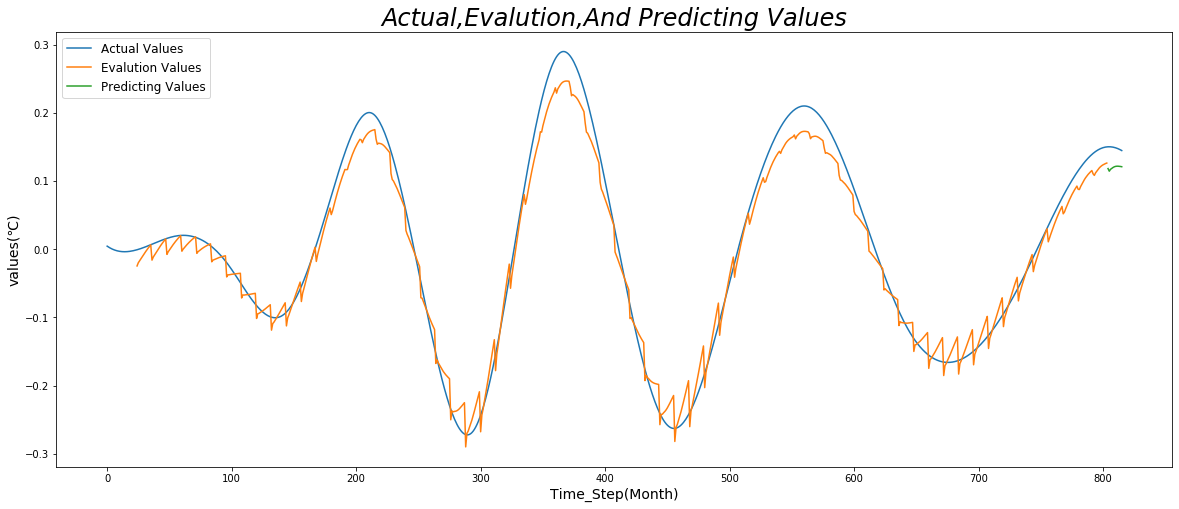

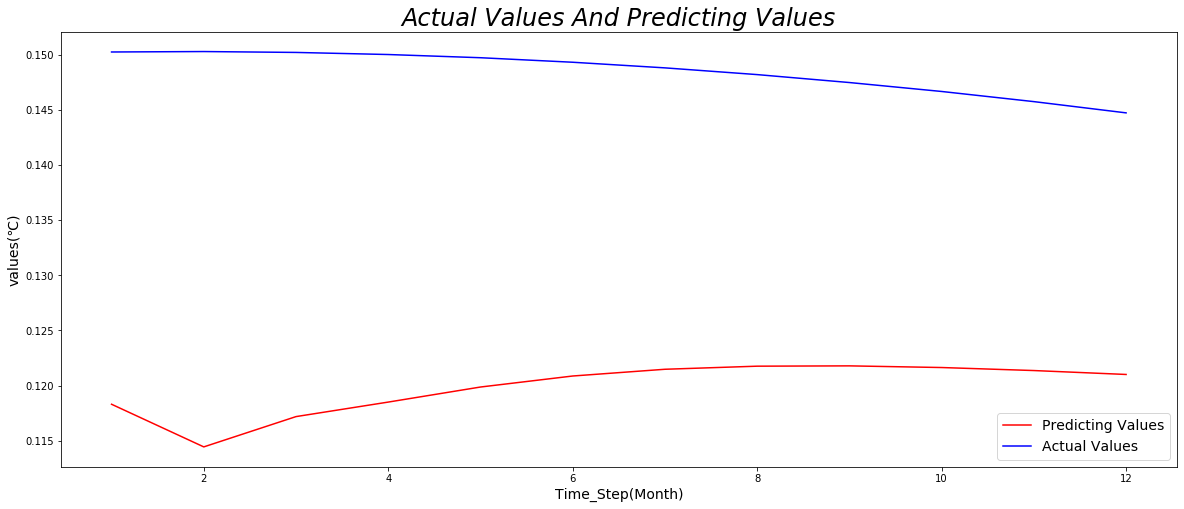

0     -0.128870
1     -0.129560
2     -0.130220
3     -0.130840
4     -0.131420
5     -0.131980
6     -0.132490
7     -0.132970
8     -0.133420
9     -0.133820
10    -0.134180
11    -0.134510
12    -0.134790
13    -0.135040
14    -0.135240
15    -0.135390
16    -0.135510
17    -0.135570
18    -0.135590
19    -0.135570
20    -0.135490
21    -0.135360
22    -0.135190
23    -0.134960
24    -0.134680
25    -0.134340
26    -0.133950
27    -0.133510
28    -0.133020
29    -0.132470
         ...   
786   -0.110260
787   -0.109000
788   -0.107750
789   -0.106510
790   -0.105280
791   -0.104060
792   -0.102850
793   -0.101660
794   -0.100470
795   -0.099299
796   -0.098139
797   -0.096992
798   -0.095858
799   -0.094737
800   -0.093630
801   -0.092538
802   -0.091461
803   -0.090398
804   -0.089351
805   -0.088320
806   -0.087305
807   -0.086306
808   -0.085325
809   -0.084360
810   -0.083413
811   -0.082483
812   -0.081570
813   -0.080674
814   -0.079795
815   -0.078933
Name: f6, Length: 816, d

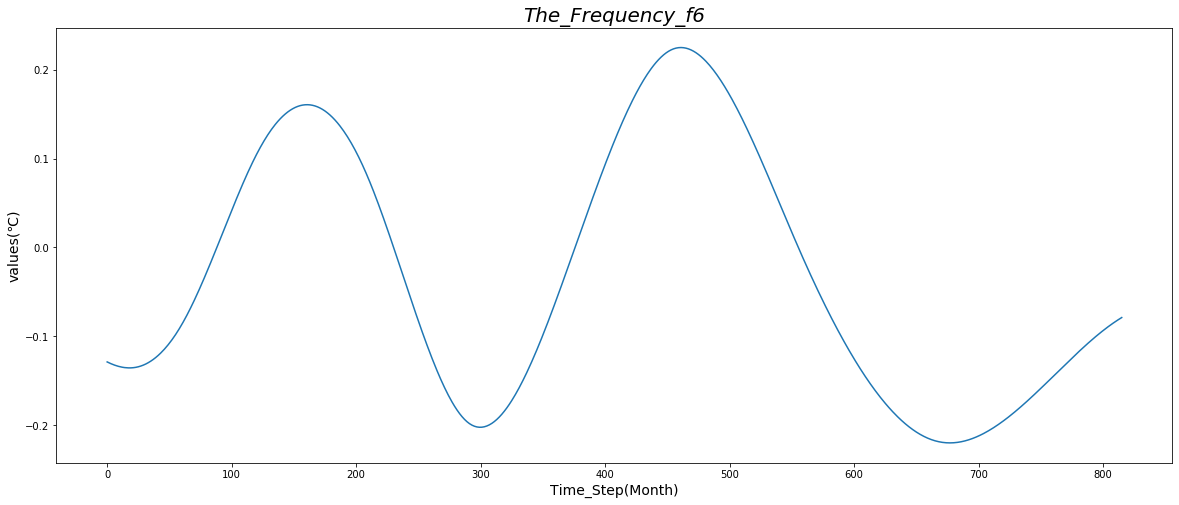

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 8s - loss: 0.0103
Epoch 2/200
 - 3s - loss: 0.0037
Epoch 3/200
 - 3s - loss: 0.0017
Epoch 4/200
 - 3s - loss: 7.2173e-04
Epoch 5/200
 - 3s - loss: 2.7997e-04
Epoch 6/200
 - 3s - loss: 9.9352e-05
Epoch 7/200
 - 3s - loss: 6.4647e-05
Epoch 8/200
 - 3s - loss: 3.9989e-05
Epoch 9/200
 - 3s - loss: 4.5255e-05
Epoch 10/200
 - 3s - loss: 2.2108e-05
Epoch 11/200
 - 3s - loss: 3.0160e-05
Epoch 12/200
 - 3s - loss: 4.8745e-05
Epoch 13/200
 - 3s - loss: 4.8532e-05
Epoch 14/200
 - 3s - loss: 3.9544e-05
Epoch 15/200
 - 3s - loss: 3.5110e-05
Epoch 16/200
 - 3s - loss: 2.5708e-05
Epoch 17/200
 - 3s - loss: 1.7373e-05
Epoch 18/200
 - 3s - loss: 1.5837e-05
Epoch 19/200
 - 3s - loss: 1.0914e-05
Epoch 20/200
 - 3s - loss: 2.2726e-05
Epoch 21/200
 - 3s - loss: 2.1666e-05
Epoch 22/200
 - 3s - loss: 1.3795e-05
Epoch 23/200
 - 3s - loss: 1.2846e-05
Epoch 24/200
 - 3s - loss: 3.2284e-05
Epoch 25/200
 - 3s - loss: 3.7275e-05
Epoch 26/200
 - 3s - loss: 1.1854e-05
Epoch 27/200
 - 3s - loss: 1.9488

(65, 12)


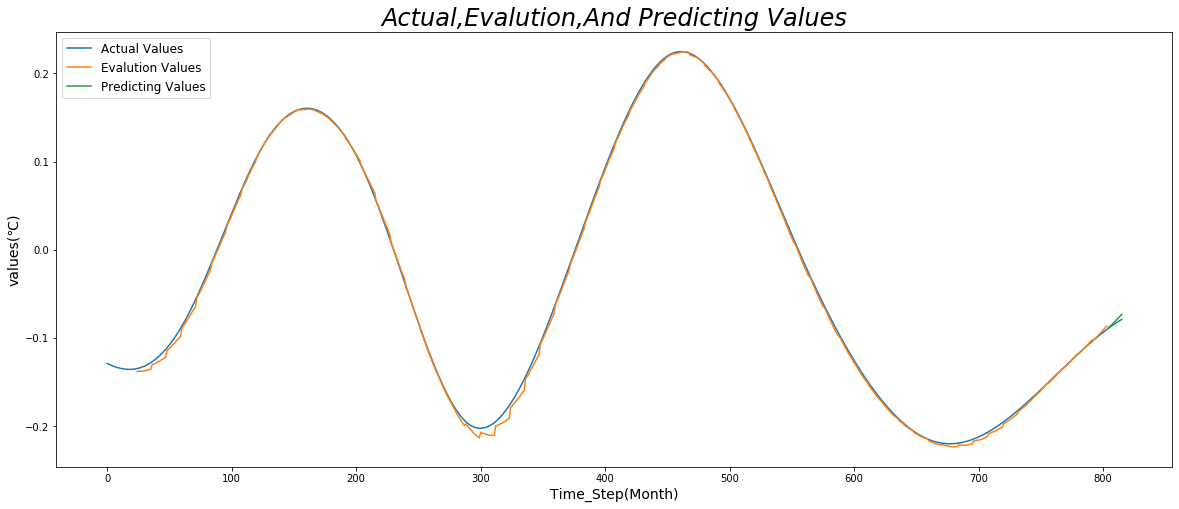

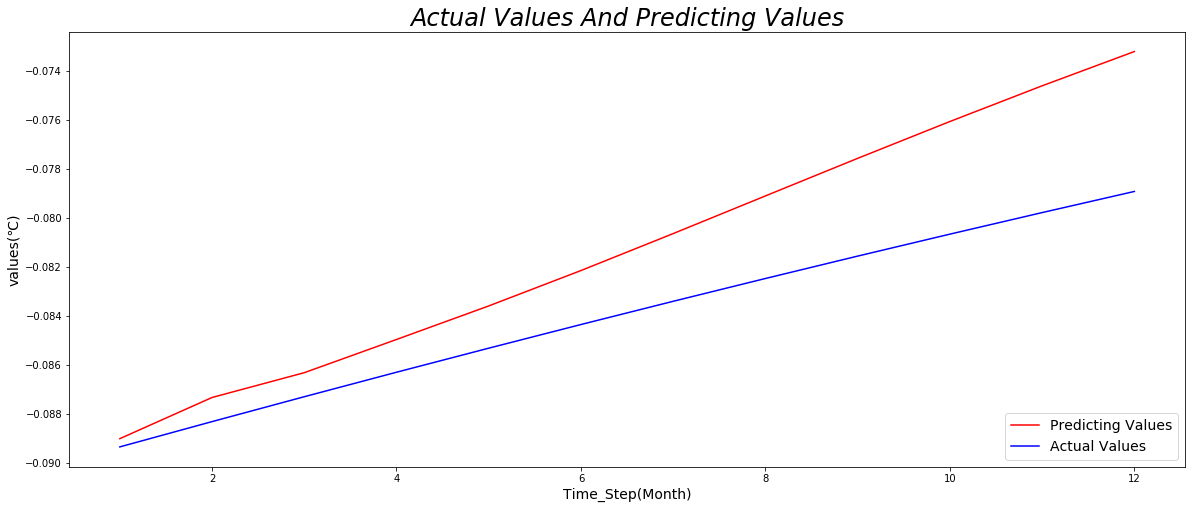

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
786    0.035310
787    0.035110
788    0.034909
789    0.034706
790    0.034502
791    0.034295
792    0.034087
793    0.033877
794    0.033666
795    0.033453
796    0.033238
797    0.033021
798    0.032803
799    0.032583
800    0.032362
801    0.032139
802    0.031914
803    0.031688
804    0.031460
805    0.031231
806    0.031000
807    0.030767
808    0.030533
809    0.030298
810    0.030061
811    0.029823
812    0.029583
813    0.029342
814    0.029099
815    0.028855
Name: f7, Length: 816, d

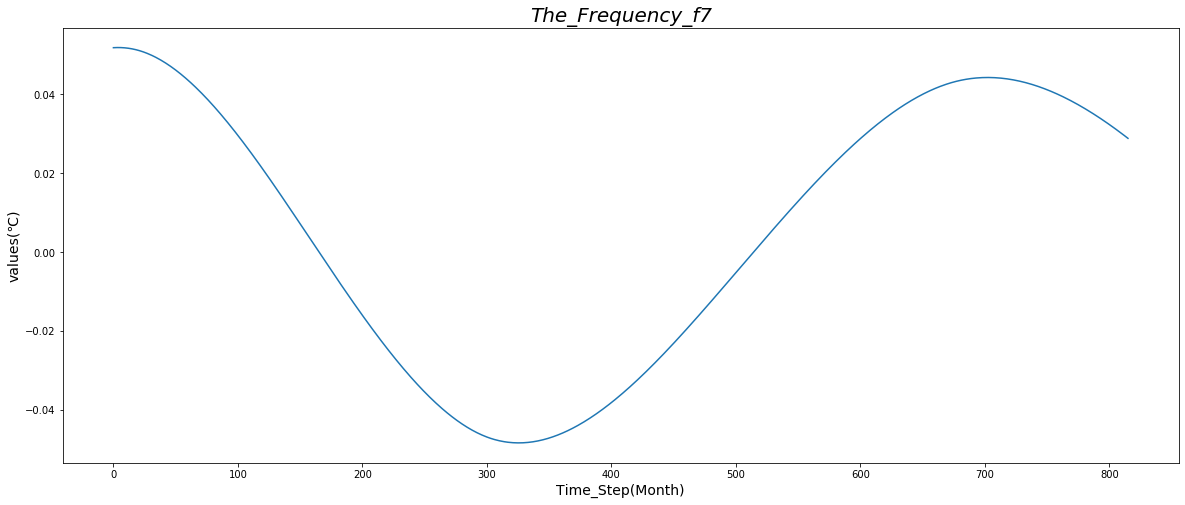

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 8s - loss: 7.1058e-04
Epoch 2/200
 - 2s - loss: 1.9878e-04
Epoch 3/200
 - 2s - loss: 1.1543e-04
Epoch 4/200
 - 2s - loss: 7.1532e-05
Epoch 5/200
 - 2s - loss: 5.2561e-05
Epoch 6/200
 - 2s - loss: 4.0959e-05
Epoch 7/200
 - 2s - loss: 3.2589e-05
Epoch 8/200
 - 2s - loss: 2.7056e-05
Epoch 9/200
 - 2s - loss: 2.4730e-05
Epoch 10/200
 - 2s - loss: 3.2261e-05
Epoch 11/200
 - 2s - loss: 2.2763e-05
Epoch 12/200
 - 2s - loss: 2.3289e-05
Epoch 13/200
 - 2s - loss: 2.3852e-05
Epoch 14/200
 - 2s - loss: 2.3498e-05
Epoch 15/200
 - 2s - loss: 1.6123e-05
Epoch 16/200
 - 2s - loss: 1.0684e-05
Epoch 17/200
 - 2s - loss: 1.5552e-05
Epoch 18/200
 - 2s - loss: 1.2917e-05
Epoch 19/200
 - 2s - loss: 1.1490e-05
Epoch 20/200
 - 2s - loss: 9.4212e-06
Epoch 21/200
 - 2s - loss: 4.2976e-06
Epoch 22/200
 - 2s - loss: 1.7075e-06
Epoch 23/200
 - 2s - loss: 9.4470e-07
Epoch 24/200
 - 2s - loss: 6.4029e-07
Epoch 25/200
 - 2s - loss: 7.3292e-07
Epoch 26/200
 - 2s - loss: 1.1261e-06
Epoch 27/200
 - 2s - 

(65, 12)


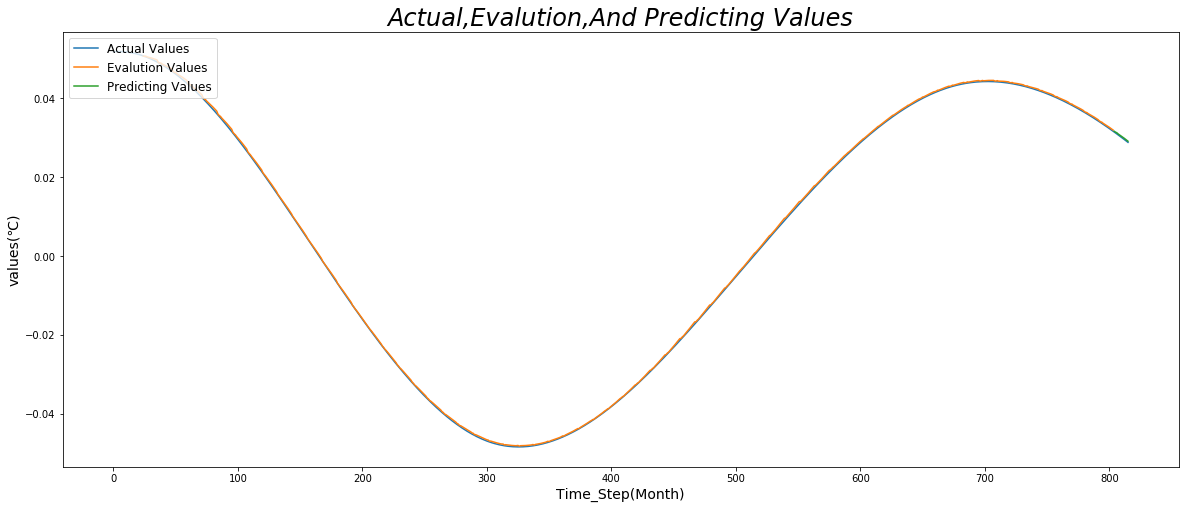

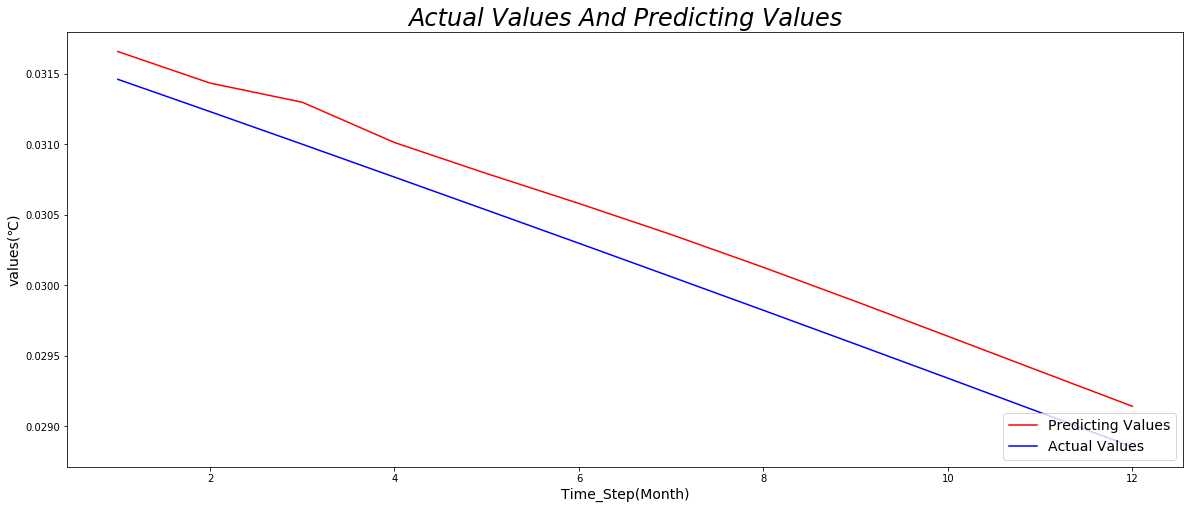

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
786    0.077683
787    0.077679
788    0.077675
789    0.077671
790    0.077667
791    0.077663
792    0.077659
793    0.077655
794    0.077651
795    0.077647
796    0.077643
797    0.077639
798    0.077635
799    0.077631
800    0.077628
801    0.077624
802    0.077620
803    0.077617
804    0.077613
805    0.077610
806    0.077606
807    0.077603
808    0.077600
809    0.077596
810    0.077593
811    0.077590
812    0.077586
813    0.077583
814    0.077580
815    0.077577
Name: f8, Length: 816, d

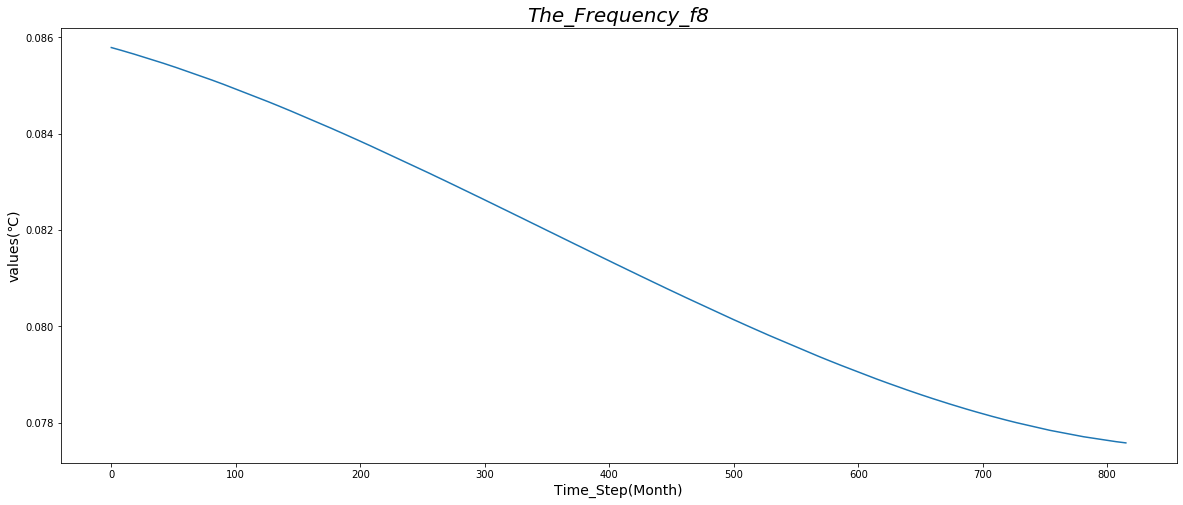

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 11s - loss: 5.2487e-04
Epoch 2/200
 - 4s - loss: 1.4564e-05
Epoch 3/200
 - 4s - loss: 7.3856e-06
Epoch 4/200
 - 4s - loss: 6.8543e-06
Epoch 5/200
 - 4s - loss: 6.7000e-06
Epoch 6/200
 - 4s - loss: 6.7832e-06
Epoch 7/200
 - 4s - loss: 6.6024e-06
Epoch 8/200
 - 3s - loss: 6.5164e-06
Epoch 9/200
 - 4s - loss: 6.7342e-06
Epoch 10/200
 - 4s - loss: 6.5887e-06
Epoch 11/200
 - 3s - loss: 6.7541e-06
Epoch 12/200
 - 3s - loss: 6.4996e-06
Epoch 13/200
 - 3s - loss: 6.4344e-06
Epoch 14/200
 - 4s - loss: 6.3667e-06
Epoch 15/200
 - 4s - loss: 6.3798e-06
Epoch 16/200
 - 3s - loss: 6.4210e-06
Epoch 17/200
 - 3s - loss: 6.4615e-06
Epoch 18/200
 - 3s - loss: 6.5110e-06
Epoch 19/200
 - 3s - loss: 6.9706e-06
Epoch 20/200
 - 3s - loss: 6.6133e-06
Epoch 21/200
 - 3s - loss: 6.7186e-06
Epoch 22/200
 - 3s - loss: 7.5471e-06
Epoch 23/200
 - 3s - loss: 7.4354e-06
Epoch 24/200
 - 3s - loss: 6.9025e-06
Epoch 25/200
 - 3s - loss: 6.3143e-06
Epoch 26/200
 - 3s - loss: 6.2777e-06
Epoch 27/200
 - 3s -

(65, 12)


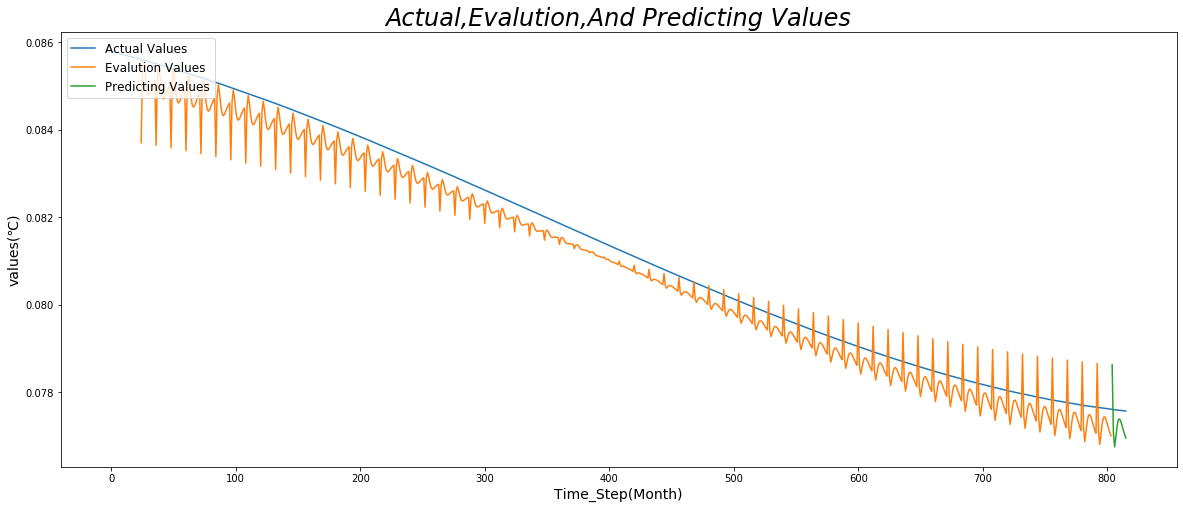

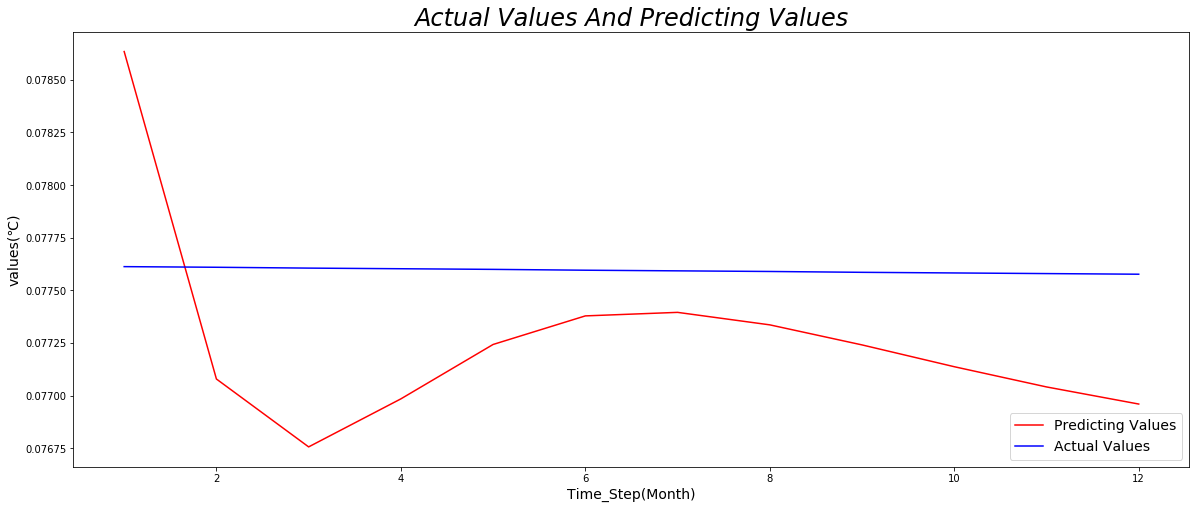

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-12]
    print (dataset)
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (train)
    print (train[0].reshape(-1))
    print (test)
    print (test[0].reshape(-1))
    

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.0786344 ]
 [0.0770794 ]
 [0.07675698]
 [0.07698502]
 [0.07724338]
 [0.07737906]
 [0.07739582]
 [0.07733651]
 [0.07724129]
 [0.07713775]
 [0.07704172]
 [0.07696045]]
[array([-0.099234 ,  0.089021 ,  0.27267  ,  0.46095  ,  0.56309  ,
        0.58834  ,  0.44249  ,  0.2177   ,  0.0026808, -0.21386  ,
       -0.34319  , -0.39661  ]), array([ 2.7968e-04,  1.3721e-01,  2.6033e-01,  3.5727e-01,  4.1617e-01,
        4.2709e-01,  3.8450e-01,  2.9855e-01,  1.8328e-01,  5.2754e-02,
       -7.8966e-02, -1.9783e-01]), array([-0.63918, -0.67864, -0.7013 , -0.70498, -0.68793, -0.65028,
       -0.59307, -0.51916, -0.43137, -0.33233, -0.22471, -0.11117]), array([-0.17542, -0.25745, -0.33739, -0.41438, -0.48756, -0.55617,
       -0.6195 , -0.67702, -0.72876, -0.77488, -0.81557, -0.85099]), array([0.44359, 0.43905, 0.43419, 0.42906, 0.4237 , 0.41817, 0.41253,
       0.40681, 0.40109, 0.39541, 0.38981, 0.38436]), array([0.15024, 0.15028, 0.1502 , 0.15001, 0.14972, 0.14931, 0.1488 ,
       0.14819, 0.

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.099234   0.089021   0.27267    0.46095    0.56309    0.58834
  0.44249    0.2177     0.0026808 -0.21386   -0.34319   -0.39661  ]
[[-0.099234 ]
 [ 0.089021 ]
 [ 0.27267  ]
 [ 0.46095  ]
 [ 0.56309  ]
 [ 0.58834  ]
 [ 0.44249  ]
 [ 0.2177   ]
 [ 0.0026808]
 [-0.21386  ]
 [-0.34319  ]
 [-0.39661  ]]
[[-0.1 ]
 [ 0.09]
 [ 0.27]
 [ 0.46]
 [ 0.56]
 [ 0.59]
 [ 0.44]
 [ 0.22]
 [ 0.  ]
 [-0.21]
 [-0.34]
 [-0.4 ]]
-----------------------------------
observe value:[ 2.7968e-04  1.3721e-01  2.6033e-01  3.5727e-01  4.1617e-01  4.2709e-01
  3.8450e-01  2.9855e-01  1.8328e-01  5.2754e-02 -7.8966e-02 -1.9783e-01]
[[-0.09895432]
 [ 0.226231  ]
 [ 0.533     ]
 [ 0.81822   ]
 [ 0.97926   ]
 [ 1.01543   ]
 [ 0.82699   ]
 [ 0.51625   ]
 [ 0.1859608 ]
 [-0.161106  ]
 [-0.422156  ]
 [-0.59444   ]]
[[-0.1 ]
 [ 0.23]
 [ 0.53]
 [ 0.82]
 [ 0.98]
 [ 1.02]
 [ 0.83]
 [ 0.52]
 [ 0.19]
 [-0.16]
 [-0.42]
 [-0.59]]
-----------------------------------
observe value:[-0.63918 -0.67864 -0.7013  -0.70498 -

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.25387794 -0.05294775  0.00359161  0.06953724  0.11779179  0.15664122
  0.15403172  0.11848602  0.07775572  0.0521039   0.04161405  0.04001166]
[-0.25387794 -0.05294775  0.00359161  0.06953724  0.11779179  0.15664122
  0.15403172  0.11848602  0.07775572  0.0521039   0.04161405  0.04001166]
the 1 frequence:
predicted_value:[ 0.03050748  0.17578599  0.3379876   0.48703864  0.59020156  0.6215984
  0.5738814   0.4588272   0.30240372  0.13464719 -0.01781994 -0.13472562]
[-0.22337046  0.12283824  0.34157921  0.55657588  0.70799335  0.77823964
  0.72791311  0.57731322  0.38015944  0.18675109  0.02379411 -0.09471396]
the 2 frequence:
predicted_value:[-0.6200688  -0.6664842  -0.6991373  -0.71483266 -0.71250945 -0.69520515
 -0.6554652  -0.5889221  -0.49416932 -0.3718704  -0.22392963 -0.05310084]
[-0.84343924 -0.54364594 -0.35755806 -0.15825678 -0.0045161   0.08303449
  0.07244793 -0.01160886 -0.11400989 -0.1851193  -0.2001

[[-0.3]
 [-0.1]
 [ 0.1]
 [ 0.3]
 [ 0.4]
 [ 0.4]
 [ 0.2]
 [-0.1]
 [-0.4]
 [-0.7]
 [-0.9]
 [-1. ]]
[-0.41843241 -0.21173347 -0.10744654  0.01122552  0.09052058  0.10752269
  0.0299614  -0.11605551 -0.27297099 -0.38896946 -0.43848105 -0.41161876]


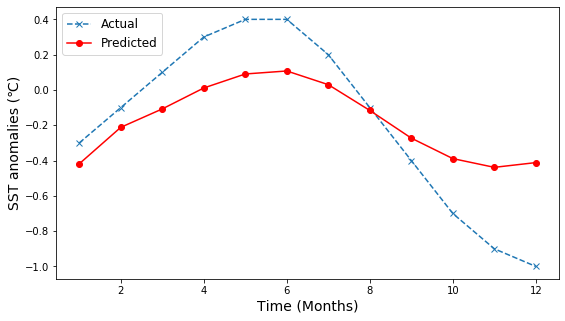

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
